Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Epoch: 0400 cost = 0.000000
Epoch: 0800 cost = 0.000000
Epoch: 1200 cost = 0.000000
Epoch: 1600 cost = 0.000000
Epoch: 2000 cost = 0.000000
['ich', 'mochte', 'ein', 'bier', 'P'] -> ['i', 'want', 'a', 'beer', 'E']


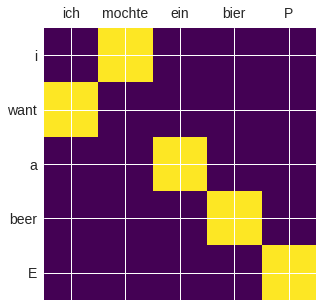

In [1]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list

# Parameter
n_step = 5  # maxium number of words in one sentence(=number of time steps)
n_hidden = 128

def make_batch(sentences):
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]
    return input_batch, output_batch, target_batch

# Model
enc_inputs = tf.placeholder(tf.float32, [None, None, n_class])  # [batch_size, n_step, n_class]
dec_inputs = tf.placeholder(tf.float32, [None, None, n_class])  # [batch_size, n_step, n_class]
targets = tf.placeholder(tf.int64, [1, n_step])  # [batch_size, n_step], not one-hot

# Linear for attention
attn = tf.Variable(tf.random_normal([n_hidden, n_hidden]))
out = tf.Variable(tf.random_normal([n_hidden * 2, n_class]))

def get_att_score(dec_output, enc_output):  # enc_output [n_step, n_hidden]
    score = tf.squeeze(tf.matmul(enc_output, attn), 0)  # score : [n_hidden]
    dec_output = tf.squeeze(dec_output, [0, 1])  # dec_output : [n_hidden]
    return tf.tensordot(dec_output, score, 1)  # inner product make scalar value

def get_att_weight(dec_output, enc_outputs):
    attn_scores = []  # list of attention scalar : [n_step]
    enc_outputs = tf.transpose(enc_outputs, [1, 0, 2])  # enc_outputs : [n_step, batch_size, n_hidden]
    for i in range(n_step):
        attn_scores.append(get_att_score(dec_output, enc_outputs[i]))

    # Normalize scores to weights in range 0 to 1
    return tf.reshape(tf.nn.softmax(attn_scores), [1, 1, -1])  # [1, 1, n_step]

model = []
Attention = []
with tf.variable_scope('encode'):
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)
    # enc_outputs : [batch_size(=1), n_step(=decoder_step), n_hidden(=128)]
    # enc_hidden : [batch_size(=1), n_hidden(=128)]
    enc_outputs, enc_hidden = tf.nn.dynamic_rnn(enc_cell, enc_inputs, dtype=tf.float32)

with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

    inputs = tf.transpose(dec_inputs, [1, 0, 2])
    hidden = enc_hidden
    for i in range(n_step):
        # time_major True mean inputs shape: [max_time, batch_size, ...]
        dec_output, hidden = tf.nn.dynamic_rnn(dec_cell, tf.expand_dims(inputs[i], 1),
                                               initial_state=hidden, dtype=tf.float32, time_major=True)
        attn_weights = get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
        Attention.append(tf.squeeze(attn_weights))

        # matrix-matrix product of matrices [1, 1, n_step] x [1, n_step, n_hidden] = [1, 1, n_hidden]
        context = tf.matmul(attn_weights, enc_outputs)
        dec_output = tf.squeeze(dec_output, 0)  # [1, n_step]
        context = tf.squeeze(context, 1)  # [1, n_hidden]

        model.append(tf.matmul(tf.concat((dec_output, context), 1), out))  # [n_step, batch_size(=1), n_class]

trained_attn = tf.stack([Attention[0], Attention[1], Attention[2], Attention[3], Attention[4]], 0)  # to show attention matrix
model = tf.transpose(model, [1, 0, 2])  # model : [n_step, n_class]
prediction = tf.argmax(model, 2)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# Training and Test
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(2000):
        input_batch, output_batch, target_batch = make_batch(sentences)
        _, loss, attention = sess.run([optimizer, cost, trained_attn],
                                      feed_dict={enc_inputs: input_batch, dec_inputs: output_batch, targets: target_batch})

        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    predict_batch = [np.eye(n_class)[[word_dict[n] for n in 'P P P P P'.split()]]]
    result = sess.run(prediction, feed_dict={enc_inputs: input_batch, dec_inputs: predict_batch})
    print(sentences[0].split(), '->', [number_dict[n] for n in result[0]])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()